In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import ks_2samp
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
# Leer datos
BASE_PATH = r"C:\Users\PERSONAL\OneDrive - UNIR\Segundo Cuatrimestre\TFM\Data"

def load_folder(folder):
    folder_path = os.path.join(BASE_PATH, folder)
    print(f"\n Carpeta {folder} - Archivos encontrados: {os.listdir(folder_path)}")

    dfs = []
    for file in os.listdir(folder_path):
        if file.endswith(".xpt"):
            file_path = os.path.join(folder_path, file)
            try:
                # Usar read_xport de pandas
                df = pd.read_sas(file_path, format="xport")
                dfs.append(df)
                print(f"{file}: {df.shape[0]} filas, {df.shape[1]} columnas")
            except Exception as e:
                print(f"Error leyendo {file}: {e}")

    if dfs:
        return pd.concat(dfs, ignore_index=True, sort=False)
    else:
        raise ValueError(f"No se pudieron cargar archivos de {folder}")


In [3]:
df_demo = load_folder("DEMO")
df_alb_cr = load_folder("ALB_CR")
df_bmx = load_folder("BMX")
df_bpx = load_folder("BPX")
df_diq = load_folder("DIQ")
df_ghb = load_folder("GHB")
df_glu = load_folder("GLU")


 Carpeta DEMO - Archivos encontrados: ['DEMO_2013_2014.xpt', 'DEMO_2015_2016.xpt', 'DEMO_2017_2018.xpt', 'DEMO_2017_2020.xpt', 'DEMO_2021_2023.xpt']
DEMO_2013_2014.xpt: 10175 filas, 47 columnas
DEMO_2015_2016.xpt: 9971 filas, 47 columnas
DEMO_2017_2018.xpt: 9254 filas, 46 columnas
DEMO_2017_2020.xpt: 15560 filas, 29 columnas
DEMO_2021_2023.xpt: 11933 filas, 27 columnas

 Carpeta ALB_CR - Archivos encontrados: ['ALB_CR_2013_2014.xpt', 'ALB_CR_2015_2016.xpt', 'ALB_CR_2017_2018.xpt', 'ALB_CR_2017_2020.xpt', 'ALB_CR_2021_2023.xpt']
ALB_CR_2013_2014.xpt: 8291 filas, 6 columnas
ALB_CR_2015_2016.xpt: 8608 filas, 8 columnas
ALB_CR_2017_2018.xpt: 7936 filas, 8 columnas
ALB_CR_2017_2020.xpt: 13027 filas, 8 columnas
ALB_CR_2021_2023.xpt: 8493 filas, 8 columnas

 Carpeta BMX - Archivos encontrados: ['BMX_2013_2014.xpt', 'BMX_2015_2016.xpt', 'BMX_2017_2018.xpt', 'BMX_2017_2020.xpt', 'BMX_2021_2023.xpt']
BMX_2013_2014.xpt: 9813 filas, 26 columnas
BMX_2015_2016.xpt: 9544 filas, 26 columnas
BMX_2017_

In [4]:
# Diccionario con los dataframes
datasets = {"DEMO": df_demo, "BMX": df_bmx, "BPX": df_bpx, "ALB_CR": df_alb_cr, "DIQ": df_diq, "GHB": df_ghb, "GLU": df_glu}

# Empezamos con DEMO como base
df_final = datasets["DEMO"]

# Hacemos merge progresivo con los demás
for name, df in datasets.items():
    if name != "DEMO":  # Evitamos volver a unir DEMO consigo mismo
        df_final = df_final.merge(df, on="SEQN", how="outer")
        print(f"Merge con {name}: {df_final.shape}")

print("\nData final:", df_final.shape)


Merge con BMX: (56893, 83)
Merge con BPX: (56893, 116)
Merge con ALB_CR: (56893, 123)
Merge con DIQ: (56893, 176)
Merge con GHB: (56893, 178)
Merge con GLU: (56893, 184)

Data final: (56893, 184)


In [5]:
df = df_final.copy()

# 0. info básica
print("Shape inicial:", df.shape)
display(df.dtypes.value_counts())
print("Columnas ejemplo:", df.columns[:30])

Shape inicial: (56893, 184)


float64    183
object       1
Name: count, dtype: int64

Columnas ejemplo: Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC',
       'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL',
       'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY',
       'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ'],
      dtype='object')


In [6]:
# Normalizar nombres de columnas (minúsculas, sin espacios)
def normalize_cols(cols):
    new = []
    for c in cols:
        c2 = c.strip().lower()
        c2 = re.sub(r'[\s\-]+', '_', c2)
        c2 = re.sub(r'[^0-9a-z_]', '', c2)
        new.append(c2)
    return new

df.columns = normalize_cols(df.columns)

In [8]:
# Ver missing values

pct_thresh=0.6

def missing_report(df, pct_thresh=0.6):
    total = len(df)
    miss = df.isna().sum().sort_values(ascending=False)
    miss_pct = (miss / total).round(4)
    rep = pd.concat([miss, miss_pct], axis=1)
    rep.columns = ['n_missing', 'pct_missing']
    return rep

# Generar reporte
mr = missing_report(df)
# Mostrar las primeras columnas
display(mr.head(80))

# Filtrar las variables con más del 60% de missing
cols_high_missing = mr[mr['pct_missing'] > pct_thresh]
display(cols_high_missing)

# Mostrar cuántas son
print(f"Cantidad de variables con >60% missing: {len(cols_high_missing)}")

,n_missing,pct_missing
bmihead,56893,1.0000
diq175x,56884,0.9998
diq175w,56881,0.9998
diq175v,56856,0.9993
diq175r,56831,0.9989
...,...,...
wtph2yr,49694,0.8735
dmdeduc3,49137,0.8637
diq070,47544,0.8357
peasctm1,47385,0.8329


,n_missing,pct_missing
bmihead,56893,1.0000
diq175x,56884,0.9998
diq175w,56881,0.9998
diq175v,56856,0.9993
diq175r,56831,0.9989
...,...,...
bpxpls,35226,0.6192
bpxpty,35211,0.6189
bpacsz,35153,0.6179
bpaarm,35143,0.6177


Cantidad de variables con >60% missing: 128


In [9]:
# Eliminar columnas con más del 60% de valores faltantes menos las de pulso pues son importantes 

# Lista de columnas importantes
keep_cols = ['bpxpls', 'bpxopls1', 'bpxopls2', 'bpxopls3']

# Identifica columnas con >60% missing
cols_to_drop = df.columns[df.isna().mean() > 0.6]

# Excluye las que se quieren conservar
cols_to_drop = [c for c in cols_to_drop if c not in keep_cols]

# Elimina solo las demás
df = df.drop(columns=cols_to_drop)

print(f"Columnas eliminadas: {len(cols_to_drop)}")
print(f"Columnas restantes: {df.shape[1]}")

Columnas eliminadas: 124
Columnas restantes: 60


In [10]:
# Eliminar columnas con varianza casi nula
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(df.select_dtypes(include=['number']))
low_var_cols = df.select_dtypes(include=['number']).columns[~selector.get_support()]
df = df.drop(columns=low_var_cols)

#se eliminaron 3 quedaron 57

In [11]:
# Eliminar columnas que no aportan valor predictivo

# Lista de variables a eliminar
cols_remove = [
    'dmqmiliz',   # Sirvió en servicio activo en el ejército
    'dmdcitzn',   # Estado de ciudadanía
    'mialang',    # Idioma de la entrevista MEC
    'miaintrp',   # Intérprete utilizado para entrevista MEC
    'aialanga',   # Idioma de la entrevista de ACASI
    'dmdhhsza',   # Número de niños de 5 años o menos en el hogar
    'dmdhhszb',   # Número de niños de 6 a 17 años en el hogar
    'dmdhhsze',   # Número de adultos de 60 años o más en el hogar
    'dmdhhsiz',   # Número total de personas en el hogar
    'dmdfmsiz',   # Número total de personas en la familia
    'indhhin2',   # Ingresos anuales del hogar
    'indfmin2',    # Ingresos familiares anuales
    'fialang', 'fiaintrp', 'sialang', 'siaintrp', 'siaproxy'  # idioma / entrevista
]

# Eliminar
df = df.drop(columns=[c for c in cols_remove if c in df.columns])

#quedaron 40

In [ ]:
# Limpieza: poner NaN  a los valores 7, 77, 9 y 99 pues representan respuestas inválidas o no informadas 

df['dmdeduc2'] = df['dmdeduc2'].replace({7: np.nan, 9: np.nan})

df['diq050'] = df['diq050'].replace({7: np.nan, 9: np.nan})

nhanes_missing_codes = {
    'diq160': [7, 9],
    'diq180': [7, 9],
    'diq010': [7, 9],
    'dmdborn4': [77, 99]
}

for col, codes in nhanes_missing_codes.items():
    df[col] = df[col].replace(codes, np.nan)


In [14]:
# Variables de Pulso
# 'bpxpls': 'Distribución de Pulso (frecuencia cardíaca, en latidos por minuto)'). Solo aplica 2013-2016
# 'bpxpuls':'Distribución de Pulso regular o irregular')
# 'bpxopls1': 'Distribución de Pulso oscilométrico 1era lectura')
# 'bpxopls2': 'Distribución de Pulso oscilométrico 2nda lectura'
# 'bpxopls3': 'Distribución de Pulso oscilométrico 3era lectura')

# Crear una variable con el promedio de las tres lecturas del pulso bpxopls1, bpxopls2, bpxopls3
df['pulse_osc'] = df[['bpxopls1', 'bpxopls2', 'bpxopls3']].mean(axis=1)

# Unificar en una sola variable “pulse_rate”: Combina bpxpls y pulse_osc en una única variable continua
df['pulse_rate'] = df['bpxpls'].combine_first(df['pulse_osc'])

# Lista de columnas a eliminar
cols_pulse_remove = ['pulse_osc', 'bpxopls1', 'bpxopls2', 'bpxopls3', 'bpxpuls', 'bpxpls']

df = df.drop(columns=[c for c in cols_pulse_remove if c in df.columns])

In [ ]:
# Revisar si hay duplicados por SEQN
if 'seqn' in df.columns:
    dup = df.duplicated(subset=['seqn']).sum()
    print("Duplicados por SEQN:", dup)

else:
    print("No se encontró columna SEQN.")

In [ ]:
# Detectar columnas de interés NHANES
candidatas = {
    'a1c': ['lbxgh'], # glucosa
    'urine_albumin': ['urxuma'],
    'urine_creatinine': ['urxucr'],
    'age': ['ridageyr'],
    'sex': ['riagendr'],
    'weight': ['bmxwt'],
    'height': ['bmxht'],
    'bmi': ['bmxbmi'],
    'diq': ['diq010']
}

found = {}
for key, subs in candidatas.items():
    for sub in subs:
        matches = [c for c in df.columns if sub in c]
        if matches:
            found[key] = matches[0]
            break
    else:
        found[key] = None

print("Columnas importantes:")
for k, v in found.items():
    print(f"{k:15s} -> {v}")

In [ ]:
# Ingeniería de variables clínicas

# Crear categorías clínicas a partir de bmxbmi (aporta Interpretabilidad, Variable categórica clínica clara)
df['bmi_cat'] = pd.cut(
    df['bmxbmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['underweight', 'normal', 'overweight', 'obese']
)

# Crear variable target: diabetes

def create_diabetes_label(row):
    """
    Crea etiqueta binaria de diabetes usando criterios NHANES / ADA:
    - DIQ010 == 1 (diagnóstico médico)
    - Glucosa en ayunas (LBXGH) >= 126 mg/dL
    """

    # 1. Autorreporte médico (NHANES DIQ010)
    try:
        if int(row['diq010']) == 1:
            return 1
    except:
        pass

    # 2. Glucosa en ayunas
    try:
        if float(row['lbxgh']) >= 126:
            return 1
    except:
        pass

    return 0

df['diabetes_label'] = df.apply(
    create_diabetes_label,
    axis=1
)

print(
    df['diabetes_label']
    .value_counts(normalize=True)
)

# 1: 8.8%

In [ ]:
# Crear un proxy de enfermedad renal crónica (CKD) 

def create_possible_ckd_proxy(row):
    try:
        # Creatinina urinaria elevada
        high_ur_creatinine = row['urxucr'] > 300  # umbral conservador
        
        # Actividad urinaria anómala
        abnormal_urdact = row['urdact'] > np.nanpercentile(df['urdact'], 90)
        
        # Riesgo mayor en adultos mayores
        age_risk = row['ridageyr'] >= 60
        
        if high_ur_creatinine and abnormal_urdact:
            return 1
        if age_risk and high_ur_creatinine:
            return 1
        return 0
    except:
        return np.nan

df['possible_ckd'] = df.apply(create_possible_ckd_proxy, axis=1)

print("Distribución possible_ckd:")
print(df['possible_ckd'].value_counts(normalize=True, dropna=False))

In [ ]:
# Selección de features para modelado

exclude = ([
    'seqn',                 # identificador
    'diabetes_label',       # target
    'possible_ckd',         # target
    'wtmec2yr', 'wtint2yr'  # pesos muestrales (no predictores) Los pesos se utilizan para análisis poblacionales, no para predicción individual.
    'sddsrvyr', 'ridstatr', 'sdmvpsu', 'sdmvstra', # Diseño muestral
    'urdact_log', 'urdact_scaled', 'urdact_imputed', # Variables auxiliares de imputación
    'miss_dmdeduc2','miss_diq050','miss_dmdhrgnd'
    ]
)

feature = [
    c for c in df.columns
    if c not in exclude
    and df[c].dtype in [np.float64, np.int64]
]

print(f"Número de variables candidatas: {len(feature)}")
print(feature)


In [ ]:
# Definir X e y
X = df.drop(columns=exclude, errors='ignore')
y = df['diabetes_label']


In [ ]:
# train/test split (estratificado por diabetes_label)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(X_train.shape, X_test.shape)

print("Distribución en train:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en test:")
print(y_test.value_counts(normalize=True))

In [ ]:
# Variables numéricas
numeric_features = [
    'ridageyr', 'indfmpir',
    'bmxwt', 'bmxht', 'bmxbmi', 'bmxleg', 'bmxarml', 'bmxarmc', 'bmxwaist',
    'urxuma', 'urxums', 'urxucr', 'urxcrs', 'urdact', 'urdumalc',
    'lbxgh', 'pulse_rate',
    'lbxgh_missing', 'urdact_missing', 'indfmpir_missing'
]

In [ ]:
# Detectar colinealidad fuerte

# Matriz de correlación
corr_matrix = df[numeric_features].corr(method='pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlación de Pearson'}
)
plt.title('Matriz de correlación de variables numéricas', fontsize=14)
plt.tight_layout()
plt.show()


# Enmascarar correlaciones débiles
threshold = 0.7
corr_strong = corr_matrix.where(abs(corr_matrix) >= threshold)

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_strong,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Correlación |r| ≥ 0.7'}
)
plt.title('Correlaciones fuertes entre variables numéricas', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
###########################
#Hasta aquí

In [13]:
# 
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_table = pd.DataFrame({
    'n_missing': missing,
    'pct_missing': missing_pct.round(2)
})

print(missing_table[missing_table['n_missing'] > 0].sort_values(by='pct_missing', ascending=False))

          n_missing  pct_missing
bpxopls3      40001        70.31
bpxopls2      39940        70.20
bpxopls1      39905        70.14
bpxpls        35226        61.92
bpxpuls       29787        52.36
diq050        26135        45.94
dmdhrgnd      23378        41.09
dmdeduc2      22861        40.18
lbxgh         21427        37.66
diq160        21329        37.49
urdumalc      20318        35.71
diq180        20262        35.61
bmxleg        17359        30.51
wtmec2yr      15560        27.35
wtint2yr      15560        27.35
urxucr        12266        21.56
urxcrs        12266        21.56
urxuma        12266        21.56
urxums        12266        21.56
urdact        12267        21.56
bmxwaist      11554        20.31
bmxbmi         9469        16.64
bmxht          9385        16.50
bmxarmc        8397        14.76
bmxarml        8381        14.73
indfmpir       7310        12.85
bmxwt          6316        11.10
ridexmon       5672         9.97
bmdstats       5672         9.97
diq010    

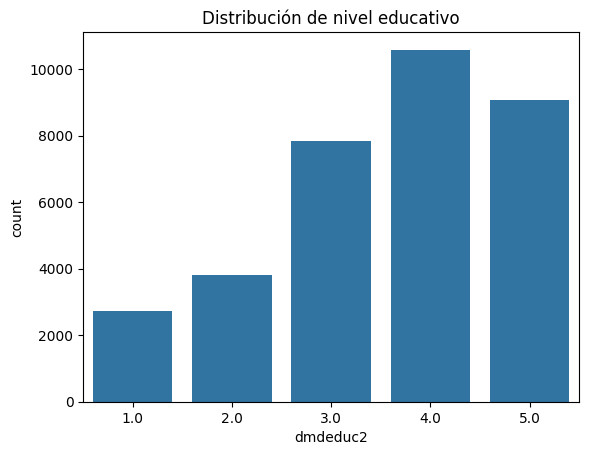

In [ ]:
# Ver distribución de variables a imputar

sns.countplot(x='dmdeduc2', data=df)
plt.title('Distribución de nivel educativo')
plt.show()

sns.countplot(x='diq050', data=df)
plt.title('Distribución de Toma insulina actualmente')
plt.show()

sns.countplot(x='dmdhrgnd', data=df)
plt.title('Distribución de Sexo jefe del hogar')
plt.show()

In [15]:
# Crear indicadores de missing para variables críticas

# Lista de variables críticas
vars_missing_indicators = ['dmdeduc2', 'diq050', 'dmdhrgnd']

# Crear columnas binarias de missing
for var in vars_missing_indicators:
    df[f'miss_{var}'] = df[var].isna().astype(int)

In [ ]:
# Imputación de dmdhrgnd (variable con distribucion uniforme) - aunque esta tiene relevancia clínica casi nula, puede aportar robustez sociodemográfica pero eliminarla puede reducir ruido
# Calcular proporciones
p = df['dmdhrgnd'].value_counts(normalize=True)

# Imputar aleatoriamente según proporción
df['dmdhrgnd'] = df['dmdhrgnd'].apply(
    lambda x: np.random.choice(p.index, p=p.values) if pd.isna(x) else x
)

# diq050 imputación por moda
for col in ['diq050']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# Imputación de dmdeduc2
def rf_probabilistic_impute(df, target, predictors, m=3, random_state=42):
    df = df.copy()
    miss_idx = df[df[target].isna()].index

    imputations = []

    for i in range(m):
        df_i = df.copy()

        obs = df_i[df_i[target].notna()]
        miss = df_i[df_i[target].isna()]

        X_train = obs[predictors]
        y_train = obs[target].astype(int)

        X_pred = miss[predictors]

        # imputación simple en predictores
        X_train = X_train.fillna(X_train.median())
        X_pred  = X_pred.fillna(X_train.median())

        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_leaf=50,
            class_weight='balanced',
            random_state=random_state + i,
            n_jobs=2
        )

        rf.fit(X_train, y_train)

        # probabilidades
        probs = rf.predict_proba(X_pred)
        classes = rf.classes_

        sampled = [
            np.random.choice(classes, p=p)
            for p in probs
        ]

        df_i.loc[miss_idx, target] = sampled
        imputations.append(df_i)

    return imputations

# Predictores
educ_predictors = [
    'ridageyr',
    'riagendr',
    'ridreth1',
    'dmdborn4',
    'indfmpir',
    'ridexmon'
]

educ_imputations = rf_probabilistic_impute(
    df,
    target='dmdeduc2',
    predictors=educ_predictors,
    m=3
)

# usamos una de las imputaciones
df = educ_imputations[0]


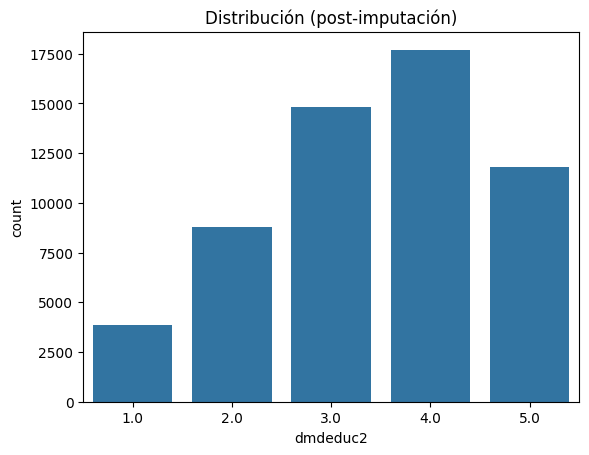

In [ ]:
# Graficamos las variables imputadas

sns.countplot(x='dmdeduc2', data=df)
plt.title('Distribución (post-imputación)')
plt.show()

sns.countplot(x='dmdhrgnd', data=df)
plt.title('Distribución (post-imputación)')
plt.show()

sns.countplot(x='diq050', data=df)
plt.title('Distribución  (post-imputación)')
plt.show()

In [ ]:
# Lista de variables para crear indicadores de missing
vars_flag = [
    'lbxgh', 'urdact', 'indfmpir'
]

# Crear los indicadores
for col in vars_flag:
    df[col + "_missing"] = df[col].isna().astype(int)


In [ ]:
# División de variables por categoría

# Biológicas
bio_cont = [
    'lbxgh', 'urdumalc', 'urxucr', 'urxuma',
    'urxcrs', 'urxums', 'urdact'
]

# Antropométricas
anthro = [
    'bmxleg', 'bmxwaist', 'bmxbmi', 'bmxht',
    'bmxarmc', 'bmxarml', 'bmxwt'
]

# Variables de peso
weights = ['wtmec2yr', 'wtint2yr']

# Categóricas
categorical = [
    'diq160', 'diq180', 'diq010',
    'ridexmon', 'bmdstats', 'dmdborn4'
]


In [ ]:
# Modelo de imputación por bloques
def rf_impute_once(
    df, target, predictors,
    model_type='regression',
    random_state=42
):
    df = df.copy()

    observed = df[df[target].notna()]
    missing = df[df[target].isna()]

    if missing.empty:
        return df

    X_train = observed[predictors].copy()
    y_train = observed[target]
    X_pred = missing[predictors].copy()

    # Blindaje contra NaNs en predictores
    medians = X_train.median(numeric_only=True)
    X_train = X_train.fillna(medians)
    X_pred  = X_pred.fillna(medians)

    # Modelo
    if model_type == 'regression':
        model = RandomForestRegressor(
            n_estimators=30,
            max_depth=6,
            min_samples_leaf=100,
            max_features='sqrt',
            n_jobs=2,
            random_state=random_state
        )
    else:
        y_train = y_train.round().astype(int)

        # Eliminar clases raras
        vc = y_train.value_counts(normalize=True)
        valid = vc[vc > 0.01].index
        mask = y_train.isin(valid)

        X_train = X_train.loc[mask]
        y_train = y_train.loc[mask]

        model = RandomForestClassifier(
            n_estimators=30,
            max_depth=6,
            min_samples_leaf=100,
            max_features='sqrt',
            n_jobs=2,
            random_state=random_state
        )

    model.fit(X_train, y_train)
    preds = model.predict(X_pred)

    # Ruido SOLO regresión
    if model_type == 'regression':
        resid = y_train - model.predict(X_train)
        noise = np.random.choice(resid, size=len(preds), replace=True)
        preds = preds + noise
    else:
        preds = preds.astype(int)    

    df.loc[df[target].isna(), target] = preds
    return df


In [ ]:
for var in categorical:
    print(var, df[var].dropna().unique())


In [26]:
for col in categorical:
    df[col] = df[col].astype('category')


In [ ]:
# Definir las variables predictoras de cada categoría
bio_predictors = [
    'bmxwt', 'bmxbmi',
    'diq010', 'diq160', 'diq180'
]

anthro_predictors = [
    'ridageyr', 'riagendr', 'ridreth1',
    'bmxht', 'bmxwt', 'bmxbmi', 'bmxwaist'
]

weight_predictors = ['ridageyr', 'riagendr', 'ridreth1']

core_predictors = [
    'ridageyr',     # edad
    'riagendr',     # sexo
    'ridreth1',     # etnia
    'bmxbmi',       # estado corporal
    'bmxwt',
    'bmxht'
]

cat_predictors = core_predictors + [
    'lbxgh', 'bmxbmi'
]

pulse_predictors = [
    'ridageyr',
    'riagendr',
    'bmxwt',
    'bmxbmi',
    'bmxht',
    'bmxwaist'
]


indfmpir_predictors = [
    'ridageyr',
    'riagendr',
    'ridreth1',
    'bmxwt',
    'bmxbmi',
    'bmxht'
]

In [28]:
M = 3
imputed_datasets = []

for m in range(M):
    df_k = df.copy()

    # Bloque CATEGÓRICO
    for var in categorical:
        df_k = rf_impute_once(
            df_k,
            var,
            predictors=[v for v in cat_predictors if v != var],
            model_type='classification',
            random_state=200 + m
        )

    # Bloque ANTROPOMETRÍA
    for var in anthro:
        df_k = rf_impute_once(
            df_k,
            var,
            predictors=[v for v in anthro_predictors if v != var],
            model_type='regression',
            random_state=100 + m
        )

    # BLOQUE 3: SES (indfmpir)
    df_k = rf_impute_once(
        df_k,
        target='indfmpir',
        predictors=indfmpir_predictors,
        model_type='regression',
        random_state=500 + m
    )

    # Bloque BIOQUÍMICAS SESGADAS
    for var in bio_cont:
        df_k = rf_impute_once(
            df_k,
            var,
            predictors=[v for v in bio_predictors if v != var],
            model_type='regression',
            random_state=42 + m
        )

    # Bloque PESOS
    for var in weights:
        df_k = rf_impute_once(
            df_k,
            var,
            predictors=[v for v in weight_predictors if v != var],
            model_type='regression',
            random_state=300 + m
        )

     # BLOQUE 6: FISIOLÓGICO
    df_k = rf_impute_once(
        df_k,
        target='pulse_rate',
        predictors=pulse_predictors,
        model_type='regression',
        random_state=400 + m
    )   

    imputed_datasets.append(df_k)


In [ ]:
df_imputado = imputed_datasets[0]   # usar el primer dataset imputado

In [37]:
def plot_continuous_before_after(df_orig, df_imp, var):
    plt.figure(figsize=(7,4))

    sns.histplot(
        df_orig[var].dropna(),
        color='blue',
        stat='density',
        bins=30,
        alpha=0.4,
        label='Original'
    )

    sns.histplot(
        df_imp[var],
        color='red',
        stat='density',
        bins=30,
        alpha=0.4,
        label='Imputado'
    )

    plt.title(f'Antes vs Después de imputación: {var}')
    plt.legend()
    plt.tight_layout()
    plt.show()


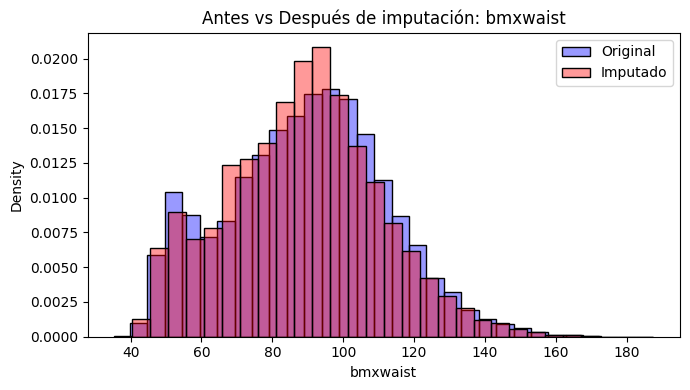

In [39]:
plot_continuous_before_after(df, df_imputado, 'bmxwaist')

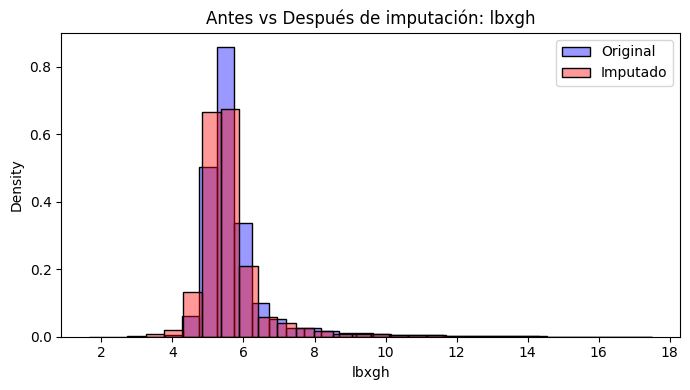

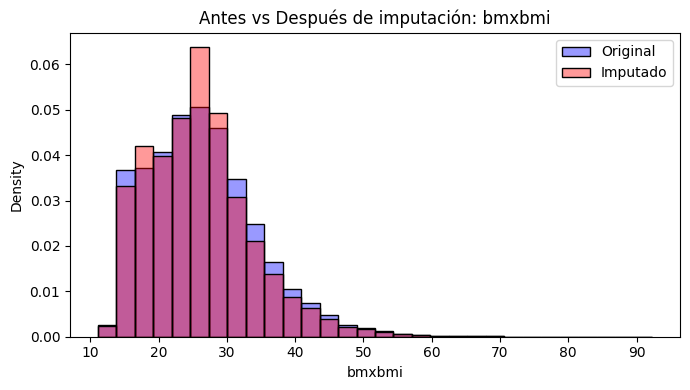

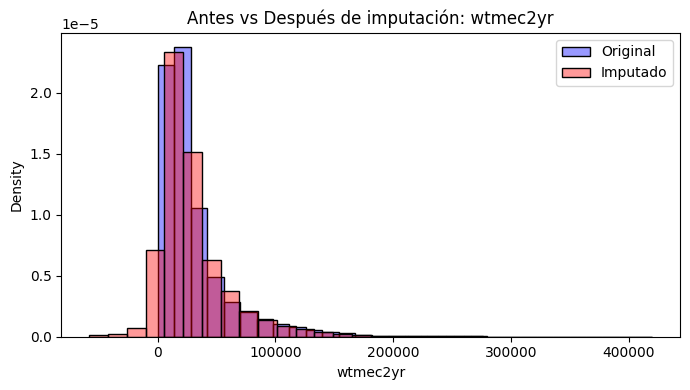

In [33]:
plot_continuous_before_after(df, df_imputado, 'lbxgh')
plot_continuous_before_after(df, df_imputado, 'bmxbmi')
plot_continuous_before_after(df, df_imputado, 'wtmec2yr')


In [32]:
def plot_categorical_before_after(df_orig, df_imp, var):
    orig = df_orig[var].value_counts(normalize=True)
    imp  = df_imp[var].round().astype(int).value_counts(normalize=True)

    comp = (
        orig.rename('Original')
        .to_frame()
        .join(imp.rename('Imputado'), how='outer')
        .fillna(0)
    )

    comp.plot(kind='bar', figsize=(7,4))
    plt.title(f'Antes vs Después de imputación: {var}')
    plt.ylabel('Proporción')
    plt.xlabel(var)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


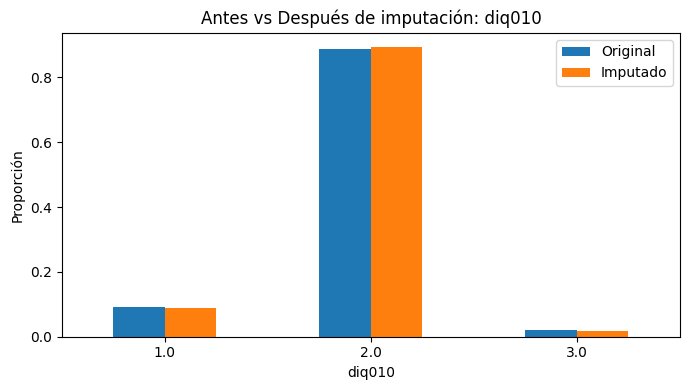

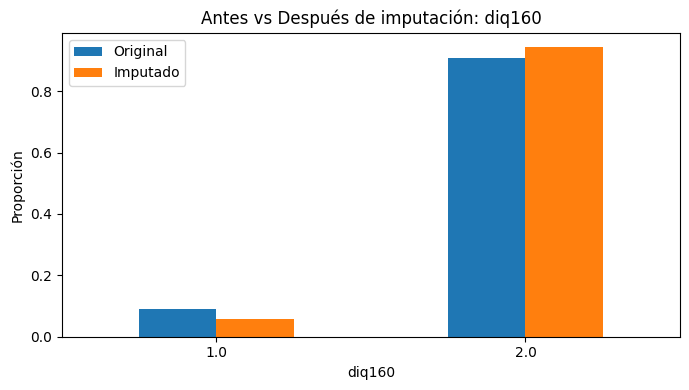

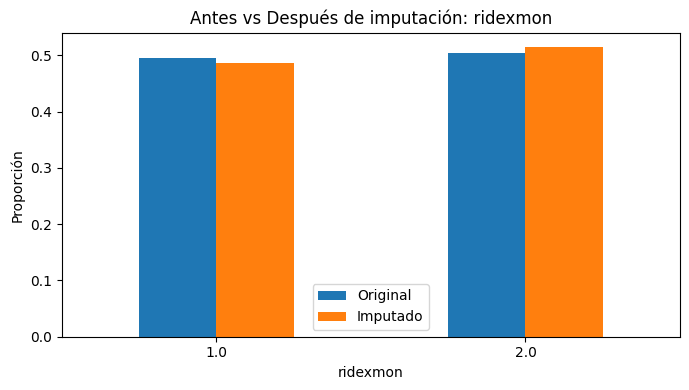

In [33]:
plot_categorical_before_after(df, df_imputado, 'diq010')
plot_categorical_before_after(df, df_imputado, 'diq160')
plot_categorical_before_after(df, df_imputado, 'ridexmon')


In [ ]:
# División de las variables en dos grupos: continuas y categóricas para evaluar las imputaciones

cont_vars = [
    'lbxgh', 'urdumalc', 'urxucr', 'urxuma',
    'urxcrs', 'urxums', 'urdact',
    'bmxleg', 'bmxwaist', 'bmxbmi', 'bmxht',
    'bmxarmc', 'bmxarml', 'bmxwt',
    'wtmec2yr', 'wtint2yr'
]

cat_vars = [
    'diq160', 'diq180', 'diq010',
    'ridexmon', 'bmdstats', 'dmdborn4'
]

# Función para evaluar las imputaciones de las variables continuas mediante estadísticos: 
# media, mediana y prueba de kolmogorov para comparar las distribuciones 

def evaluate_continuous(df_original, imputed_datasets, var):
    orig = df_original[var].dropna()

    stats = {
        'variable': var,
        'mean_original': orig.mean(),
        'median_original': orig.median()
    }

    means = []
    medians = []
    ks_stats = []

    for df_imp in imputed_datasets:
        imp = df_imp[var]

        means.append(imp.mean())
        medians.append(imp.median())

        ks = ks_2samp(orig, imp)
        ks_stats.append(ks.statistic)

    stats.update({
        'mean_imputed_avg': np.mean(means),
        'median_imputed_avg': np.mean(medians),
        'ks_stat_avg': np.mean(ks_stats),
        'between_imputation_var': np.var(means)
    })

    return stats

# Función para evaluar las imputaciones de las variables categóricas

def evaluate_categorical(df_original, imputed_datasets, var):
    orig = df_original[var].dropna().astype(int)
    orig_prop = orig.value_counts(normalize=True)

    l1_distances = []
    entropies = []

    for df_imp in imputed_datasets:
        imp = df_imp[var].round().astype(int)
        imp_prop = imp.value_counts(normalize=True)

        # Alinear categorías
        all_cats = orig_prop.index.union(imp_prop.index)
        o = orig_prop.reindex(all_cats, fill_value=0)
        i = imp_prop.reindex(all_cats, fill_value=0)

        l1_distances.append(np.abs(o - i).sum())
        entropies.append(entropy(i + 1e-8))

    return {
        'variable': var,
        'l1_distance_avg': np.mean(l1_distances),
        'entropy_avg': np.mean(entropies),
        'between_imputation_var': np.var(l1_distances)
    }

results = []

# Continuas
for var in cont_vars:
    results.append(
        evaluate_continuous(df, imputed_datasets, var)
    )

# Categóricas
for var in cat_vars:
    results.append(
        evaluate_categorical(df, imputed_datasets, var)
    )

results_df = pd.DataFrame(results)
results_df


In [ ]:
results_df_round = results_df.copy()
results_df_round = results_df_round.round(3)

In [34]:
# Re imputar urdact

df_imputado['urdact'] = df['urdact']
df_imputado['urdact_log'] = np.log1p(df_imputado['urdact'])

urdact_predictors = [
    'urxucr',      # creatinina urinaria
    'urxuma',      # albúmina urinaria
    'urxums',
    'lbxgh',       # glucosa
    'bmxbmi',
    'bmxwt',
    'ridageyr',
    'riagendr',
    'indfmpir'
]

# Transformar la variable urdact si es sesgada
df_imputado['urdact_log'] = np.log1p(df_imputado['urdact']) # Si 'urdact' tiene valores muy pequeños o ceros

# Normalizar
scaler = StandardScaler()
df_imputado['urdact_scaled'] = scaler.fit_transform(df_imputado[['urdact_log']])

# Imputación
df_imputado = rf_impute_once(
    df_imputado,
    target='urdact_scaled',  # Imputar con la versión escalada
    predictors=[v for v in urdact_predictors if v != 'urdact_scaled'],
    model_type='regression',
    random_state=500
)

# Revertir la transformación
df_imputado['urdact_imputed'] = np.expm1(df_imputado['urdact_scaled'])  # Si se hizo logaritmo antes

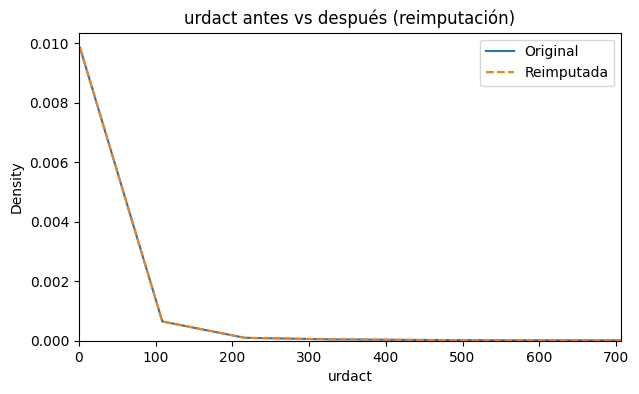

In [35]:
plt.figure(figsize=(7,4))
sns.kdeplot(df['urdact'].dropna(), label='Original')
sns.kdeplot(df_imputado['urdact'], label='Reimputada', linestyle='--')
plt.xlim(0, df['urdact'].quantile(0.99))
plt.legend()
plt.title('urdact antes vs después (reimputación)')
plt.show()


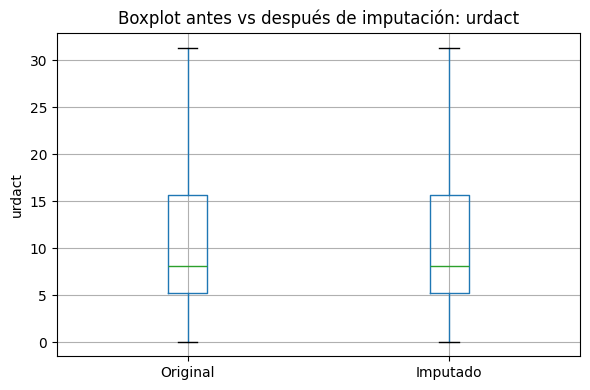

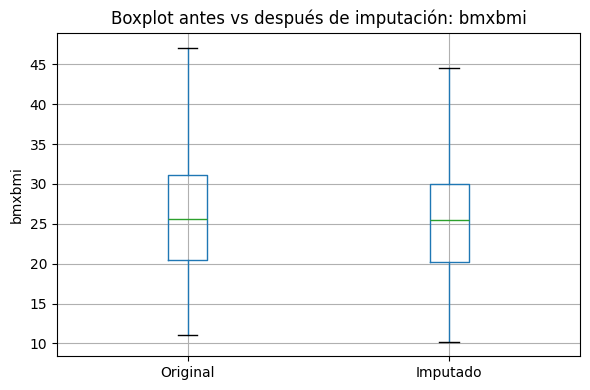

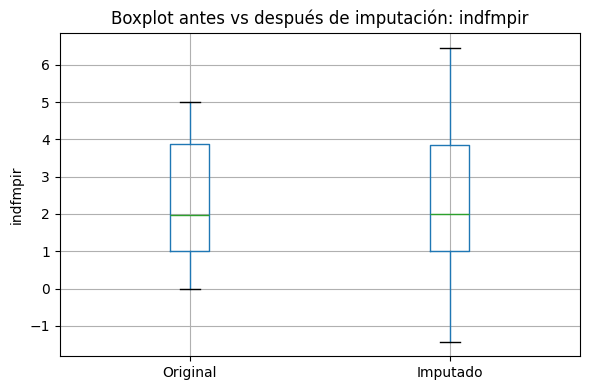

In [ ]:
# Graficamos boxplots para comparar
vars_boxplot = ['urdact', 'bmxbmi', 'indfmpir']

for var in vars_boxplot:
    data = pd.DataFrame({
        'Original': df[var],
        'Imputado': df_imputado[var]
    })

    plt.figure(figsize=(6, 4))
    data.boxplot(showfliers=False)
    plt.title(f'Boxplot antes vs después de imputación: {var}')
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()


In [ ]:
# Missing indicators que si se conservan
keep_missing = [
    'lbxgh_missing',
    'urdact_missing',
    'indfmpir_missing',
    'pulse_rate_missing'
]

# Todos los indicadores de missing
all_missing_cols = [c for c in df_imputado.columns if c.endswith('_missing')]

# Excluir variables de missing que no queremos conservar

exclude = (
    [c for c in all_missing_cols if c not in keep_missing]
)

feature = [
    c for c in df_imputado.columns
    if c not in exclude
    and df_imputado[c].dtype in [np.float64, np.int64]
]

print(f"Número de variables candidatas: {len(feature)}")
print(feature)

In [ ]:
 #
df_imputado = df_imputado.drop(columns=exclude, errors='ignore')

In [ ]:
# Codificación de categóricas 

# Variables numéricas reales
numeric_features = [
    'ridageyr', 'indfmpir',
    'bmxwt', 'bmxht', 'bmxbmi', 'bmxleg', 'bmxarml', 'bmxarmc', 'bmxwaist',
    'urxuma', 'urxums', 'urxucr', 'urxcrs', 'urdact', 'urdumalc',
    'lbxgh', 'pulse_rate',
    'lbxgh_missing', 'urdact_missing', 'indfmpir_missing'
]

# Variables categóricas
categorical_features = [
    'riagendr', 'ridreth1', 'ridreth3', 'ridexmon',
    'dmdborn4', 'dmdeduc2', 'dmdhrgnd',
    'bmdstats',
    'diq010', 'diq160', 'diq180', 'diq050',
    'bmi_cat'
]

# pipeline de preprocesado

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # seguridad
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',        # evita colinealidad
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


In [65]:
# Modelo base

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=50,
    class_weight='balanced',
    n_jobs=2,
    random_state=42
)


In [66]:
# Pipeline completo (preprocesamiento + modelo)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])


In [67]:
# Entrenamiento

rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [68]:
# Evaluación

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


ROC-AUC: 0.9999220726409821
Accuracy: 0.9917391686439934
Precision: 0.916590284142988
Recall (Sensibilidad): 0.9970089730807578
F1: 0.9551098376313276

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10376
           1       0.92      1.00      0.96      1003

    accuracy                           0.99     11379
   macro avg       0.96      0.99      0.98     11379
weighted avg       0.99      0.99      0.99     11379



In [ ]:
# Guardar datasets limpios
X_train.to_parquet("nhanes_train_clean.parquet", index=False)
X_test.to_parquet("nhanes_test_clean.parquet", index=False)
df_imputado.to_parquet("nhanes_full_clean.parquet", index=False)

print("Guardados: nhanes_train_clean.parquet, nhanes_test_clean.parquet, nhanes_full_clean.parquet")

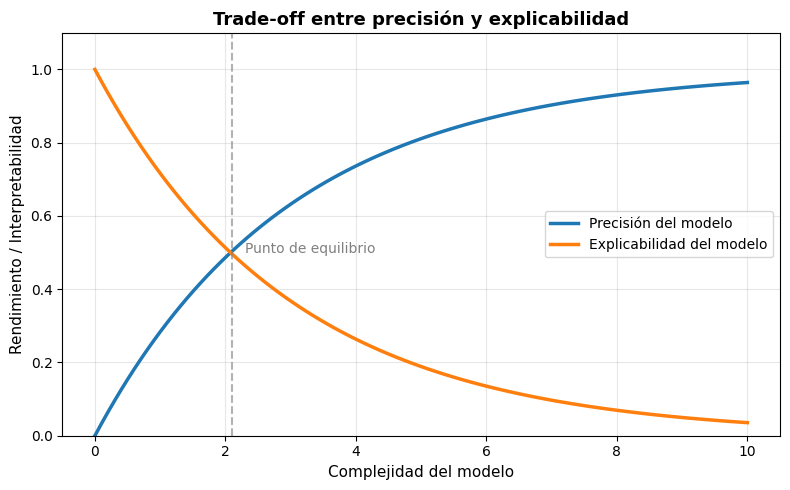

In [10]:
###############################
# Otros
###############################

# Figura 3

# Crear datos simulados
x = np.linspace(0, 10, 100)
precision = 1 - np.exp(-x/3)  # Curva creciente (más complejidad -> más precisión)
explainability = np.exp(-x/3)  # Curva decreciente (más complejidad -> menos explicabilidad)

# Crear figura
plt.figure(figsize=(8,5))
plt.plot(x, precision, label="Precisión del modelo", linewidth=2.5, color='tab:blue')
plt.plot(x, explainability, label="Explicabilidad del modelo", linewidth=2.5, color='tab:orange')
plt.axvline(2.1, color='gray', linestyle='--', alpha=0.6)
plt.text(2.3, 0.5, "Punto de equilibrio", color='gray')

# Personalización
plt.title("Trade-off entre precisión y explicabilidad", fontsize=13, weight='bold')
plt.xlabel("Complejidad del modelo", fontsize=11)
plt.ylabel("Rendimiento / Interpretabilidad", fontsize=11)
plt.ylim(0, 1.1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Mostrar
plt.show()
